In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pvlib
print(pvlib.__version__)

0.9.1


In [4]:
import datetime

# METEO à Toulouse

In [5]:
# where is Pechbusque...
# name,latitude, longitude, altitude, timezone

coordinates = {
    'Pechbusque': (43.515, 1.465, 279.0, 'Europe/Paris'),
    'Montpellier' : (43.58, 3.97, 6.0, 'Europe/Paris')   # pour comparer avec PV Watts
}

In [6]:
lieu = 'Pechbusque'

In [7]:
latitude, longitude, altitude, time_zone = coordinates[lieu]

In [8]:
# récupère infos de PV-GIS

df_weather, months, inputs, metadata = pvlib.iotools.get_pvgis_tmy(latitude=latitude,
                                                                   longitude=longitude,
                                                                   map_variables=True
                                                                   )

In [9]:
df_weather.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
temp_air,8760.0,15.158910,7.127826,-4.49,10.1600,15.00,20.0700,37.21
relative_humidity,8760.0,76.830857,16.476023,27.07,65.0675,80.30,90.8425,100.00
ghi,8760.0,155.585919,239.517266,0.00,0.0000,0.00,240.0125,993.00
dni,8760.0,157.239387,271.987149,0.00,0.0000,0.00,211.5850,1032.41
dhi,8760.0,69.294155,98.825464,0.00,0.0000,0.00,119.0000,468.00
IR(h),8760.0,304.853515,45.508030,186.55,270.0300,304.89,343.9000,407.80
wind_speed,8760.0,3.301823,1.907680,0.04,1.8800,2.79,4.4500,11.50
wind_direction,8760.0,252.021005,79.288235,0.00,185.0000,291.00,315.0000,360.00
pressure,8760.0,98577.318037,777.685085,95662.00,98103.0000,98568.00,99068.0000,100770.00


In [10]:
df_weather.head(5)

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2005-01-01 00:00:00+00:00,9.12,98.04,0.0,0.0,0.0,282.64,1.94,304.0,99986.0
2005-01-01 01:00:00+00:00,9.02,98.05,0.0,0.0,0.0,276.86,2.08,304.0,99986.0
2005-01-01 02:00:00+00:00,8.92,98.06,0.0,0.0,0.0,271.09,2.23,304.0,99986.0
2005-01-01 03:00:00+00:00,8.82,98.07,0.0,0.0,0.0,265.31,2.37,304.0,99964.0
2005-01-01 04:00:00+00:00,8.72,98.08,0.0,0.0,0.0,259.54,2.51,304.0,99941.0


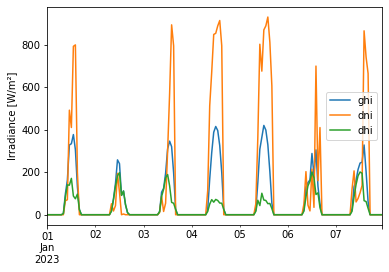

In [14]:
# Irradiance

first_week = df_weather.head(24*7)  # Plotting 7 days, each one has 24 hours or entries
first_week[['ghi', 'dni', 'dhi']].plot()
plt.ylabel('Irradiance [W/m²]')
plt.show()

In [15]:
print(f"{lieu}")
print(f"GHI annuel : {df_weather['ghi'].sum()/1000:.0f} kWh/an")
print(f"DNI annuel : {df_weather['dni'].sum()/1000:.0f} kWh/an")
print(f"DHI annuel : {df_weather['dhi'].sum()/1000:.0f} kWh/an")

Pechbusque
GHI annuel : 1363 kWh/an
DNI annuel : 1377 kWh/an
DHI annuel : 607 kWh/an


In [16]:
# travail sur le format : on force tous les timestamps pour avoir la même année : 2023

new_index_to_2023 = [ datetime.datetime(2023, d.month, d.day, d.hour, d.minute, tzinfo=d.tzinfo) for d in df_weather.index ]
new_index_to_2023 = pd.DatetimeIndex(new_index_to_2023)

df_weather = df_weather.set_index(new_index_to_2023)

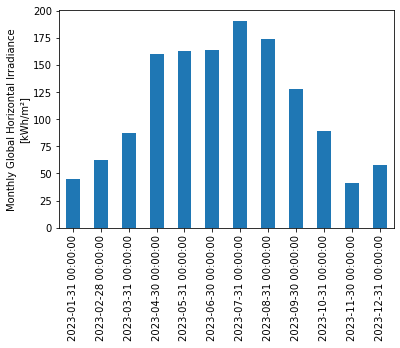

In [17]:
# données mensuelles

monthly_ghi = df_weather['ghi'].resample('M').sum()/1000  # NB : nécessite d'avoir la même année, sinon le resampling produit plus de 12 lignes
monthly_ghi = monthly_ghi.tz_localize(None)  # pour afficher sans la tz

monthly_ghi.plot.bar()

plt.ylabel('Monthly Global Horizontal Irradiance\n[kWh/m²]');

# POA Irradiance

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%202%20-%20POA%20Irradiance.html

In [18]:
# instancie un objet Location de pvlib

location = pvlib.location.Location(latitude=latitude,
                                   longitude=longitude,
                                   altitude=altitude,
                                   name=lieu,
                                   tz=time_zone
)

In [19]:
# calcul de la position du soleil, au milieu (30 mins) de chaque intervalle horaire

times = df_weather.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2023-01-01 00:00:00+00:00,158.765032,158.765032,-68.765032,-68.765032,342.413453,-3.177534
2023-01-01 01:00:00+00:00,158.443328,158.443328,-68.443328,-68.443328,20.835977,-3.197268
2023-01-01 02:00:00+00:00,152.008806,152.008806,-62.008806,-62.008806,50.456864,-3.216993
2023-01-01 03:00:00+00:00,142.579424,142.579424,-52.579424,-52.579424,69.325124,-3.236709
2023-01-01 04:00:00+00:00,132.038408,132.038408,-42.038408,-42.038408,82.546649,-3.256415


In [20]:
# POA geometry definition

tilts = {
    'dome_solar_tilt0' : 0.0,
    'flat_fix_fusion' : 13.0,
    'optimum' : 37.0
}

azimuth = 180

In [21]:
# calcule les valeurs horaires de l'irradiance POA pour les différents tilts

dfs_poa ={}

for k,tilt in tilts.items():
    dfs_poa[k] = pvlib.irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=df_weather['dni'],
        ghi=df_weather['ghi'],
        dhi=df_weather['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic'
    )

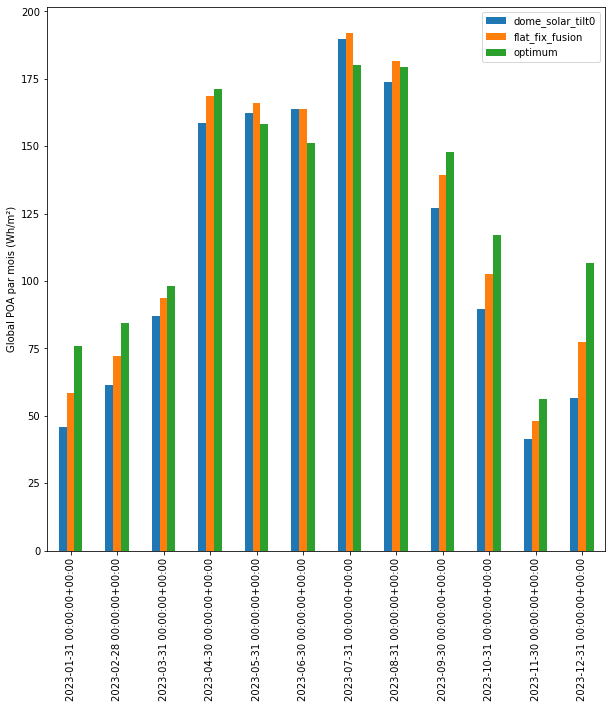

In [22]:
data_global_poa = { k : dfs_poa.get(k)['poa_global'] for k in tilts.keys() }

for k, df in dfs_poa.items():
    df_monthly = df.resample('M').sum()/1000.0
    data_global_poa[k] = df_monthly['poa_global']
    
df_summary = pd.DataFrame(data_global_poa)

df_summary = df_summary.resample('M').sum()

fig, ax = plt.subplots(figsize=(10,10))
df_summary.plot.bar(ax = ax)
plt.ylabel('Global POA par mois (Wh/m²)')
plt.show()

In [23]:
for k, df in dfs_poa.items():
    print(f"\n{k}")
    print(f"POA global annuel = {df['poa_global'].sum()/1000:.0f} kWh/m² ")


dome_solar_tilt0
POA global annuel = 1357 kWh/m² 

flat_fix_fusion
POA global annuel = 1463 kWh/m² 

optimum
POA global annuel = 1526 kWh/m² 


In [24]:
# This plot shows that, compared with a flat array, a tilted array receives significantly more insolation in the winter.
# However, it comes at the cost of slightly less insolation in the summer. 
# The difference is all about solar position – tilting up from horizontal gives a better match to solar position in winter, when the sun is low in the sky. 
# However it gives a slightly worse match in summer when the sun is very high in the sky.

# Module Temperature

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%203%20-%20Module%20Temperature.html

In [25]:
# On a déjà les données météo pour différents tilts,
# il faut maintenant le modèle de température

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

# descriptions ici : https://sam.nrel.gov/forum/forum-general/1040-mount-types.html#:~:text=Cell%2FPolymer%20Sheet-,Open%20Rack,Open%20Rack
# ""Roof mount is typical of residential installations where modules are attached to the roof surface with standoffs that providing limited air flow between the module back and roof surface (typically between two and six inches).""

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

In [26]:
parameters = all_parameters['close_mount_glass_glass']   # approprié pour les fixations à tilt = 0° (Dome Solar) et 13° (Flat Fix Fusion)

In [27]:
cell_temperature = pvlib.temperature.sapm_cell(
    dfs_poa.get('dome_solar_tilt0')['poa_global'],   # valeurs horaires de l'irradiance sur POA
    df_weather['temp_air'],
    df_weather['wind_speed'],
    **parameters
)

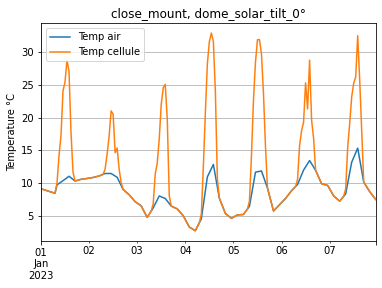

In [29]:
df_weather['temp_air'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Temp air', 'Temp cellule'])
plt.ylabel('Temperature °C')
plt.title(f"close_mount, dome_solar_tilt_0°")
plt.show()

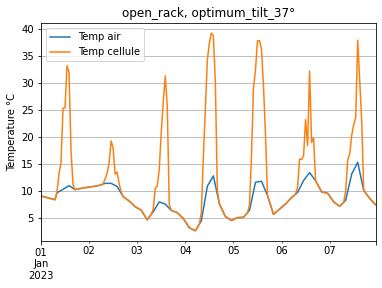

In [30]:
parameters = all_parameters['open_rack_glass_glass']   # what if... fixation à 37°C

cell_temperature = pvlib.temperature.sapm_cell(
    dfs_poa.get('optimum')['poa_global'],   # valeurs horaires de l'irradiance sur POA
    df_weather['temp_air'],
    df_weather['wind_speed'],
    **parameters
)

df_weather['temp_air'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Temp air', 'Temp cellule'])
plt.ylabel('Temperature °C')
plt.title(f"open_rack, optimum_tilt_37°")
plt.show()

# NB : meilleur refroidissment supposé, mais un peu plus de Watts, donc ça chauffe plus ?

# Module Performance

https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%204%20-%20Model%20a%20Module%27s%20Performance.html

In [31]:
# Standard Test Conditions

E0 = 1000.0 # W/m²
T0 = 25.0 # 0°C

# IEC61853 Test Matrix
E_IEC61853 = [100, 200, 400, 600, 800, 1000, 1100]  # irradiances [W/m^2]
T_IEC61853 = [15, 25, 50, 75]  # temperatures [degC]

IEC61853 = np.meshgrid(T_IEC61853, E_IEC61853)

IEC61853

[array([[15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75],
        [15, 25, 50, 75]]),
 array([[ 100,  100,  100,  100],
        [ 200,  200,  200,  200],
        [ 400,  400,  400,  400],
        [ 600,  600,  600,  600],
        [ 800,  800,  800,  800],
        [1000, 1000, 1000, 1000],
        [1100, 1100, 1100, 1100]])]

In [54]:
CECMODS = pvlib.pvsystem.retrieve_sam(name='CECMod')

CECMODS.T.columns

Index(['Technology', 'Bifacial', 'STC', 'PTC', 'A_c', 'Length', 'Width', 'N_s',
       'I_sc_ref', 'V_oc_ref', 'I_mp_ref', 'V_mp_ref', 'alpha_sc', 'beta_oc',
       'T_NOCT', 'a_ref', 'I_L_ref', 'I_o_ref', 'R_s', 'R_sh_ref', 'Adjust',
       'gamma_r', 'BIPV', 'Version', 'Date'],
      dtype='object')

In [63]:
trina_mods = CECMODS.T.index.str.startswith('Trina_Solar') & CECMODS.T.index.str.contains('TSM_375')
CECMODS.T[trina_mods]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Trina_Solar_TSM_375DE14A_II_,Mono-c-Si,0,374.8,348.8,1.92,NaN,NaN,72,9.88,48.5,...,1.818712,9.884084,0.0,0.311839,754.506287,7.608252,-0.372,N,SAM 2018.11.11 r2,1/3/2019
Trina_Solar_TSM_375DE14H_II_,Mono-c-Si,0,375.088,349.8,1.96,NaN,NaN,48,9.93,47.8,...,1.777433,10.033036,0.0,0.308714,828.678345,5.118076,-0.353,N,SAM 2018.11.11 r2,1/3/2019
Trina_Solar_TSM_375DEG14_II_,Mono-c-Si,0,375.6,349.6,1.96,NaN,NaN,72,9.71,47.5,...,1.837296,9.908375,0.0,0.194844,602.328247,14.726869,-0.378,N,SAM 2018.11.11 r2,1/3/2019
Trina_Solar_TSM_375DEG14_40_II_,Mono-c-Si,0,375.6,349.6,1.96,NaN,NaN,72,9.71,47.5,...,1.837296,9.908375,0.0,0.194844,602.328247,14.726869,-0.378,N,SAM 2018.11.11 r2,1/3/2019


In [65]:
CECMODS.T[trina_mods].mean().T

C:\Users\BENJAM~1.DEP\AppData\Local\Temp/ipykernel_1432/3137560645.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  CECMODS.T[trina_mods].mean().T


Bifacial    0.000000e+00
STC         3.752720e+02
PTC         3.494500e+02
A_c         1.950000e+00
Length               NaN
Width                NaN
N_s         6.600000e+01
I_sc_ref    9.807500e+00
V_oc_ref    4.782500e+01
I_mp_ref    9.417500e+00
V_mp_ref    3.985000e+01
alpha_sc    4.141000e-03
beta_oc    -1.306817e-01
T_NOCT      4.382500e+01
a_ref       1.817684e+00
I_L_ref     9.933467e+00
I_o_ref     4.073428e-11
R_s         2.525602e-01
R_sh_ref    6.969603e+02
Adjust      1.054502e+01
gamma_r    -3.702500e-01
dtype: float64

In [75]:
#-----------------------------------------------------------------------------------------------------
# données module Trina : sources = datasheet Trina, base CEC, autres info reprises de la db SAM
#-----------------------------------------------------------------------------------------------------

module_trina_vertex_405_CEC = {
    'Technology' : 'Mono-c-Si',
    'A_c' : 1.91,
    'N_s' : 60,
    'N_p' : 2,
    'I_sc_ref' : 12.34,
    'V_oc_ref' : 41.4,
    'I_mp_ref' : 11.77,
    'V_mp_ref' : 34.4,
    'T_NOCT' : 44.8,
    'gamma_r' : -0.357,
    'alpha_sc' : 0.033,
    'beta_oc' : -0.266,
    'a_ref' : 1.817684, # diode ideality factor - reuse TSM-375W average
    'I_L_ref' : 9.933467,  # light or photogenerated current at reference condition in A - reuse 375W average
    'I_o_ref' : 4.073428e-11, # diode saturation current at reference condition in A - reuse 375W average
    'R_s' : 0.2525602, # series resistance in Ω - reuse 375W average
    'R_sh_ref' : 696.9603, # shunt resistance at reference condition in Ω - reuse 375W average
    'Adjust' : 10.54502, # adjustment to short circuit temperature coefficient in % - reuse 375W average
    'BIPV' : 'N',  
    'PTC' : 378.0,
    'STC' : 405.0,
    'Length' : 1.754,
    'Width' : 1.096,
    "Name" : "Trina_Vertex_405Wc_TSM-DE09"
}

In [76]:
# calcul des Single Diod Parameters aux différents points du test IEC (T°C cell x irradiance)
# afin de pouvoir inférer les courbes I-V à différentes conditions

temp_cell, effective_irradiance = IEC61853

cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance=effective_irradiance,
        temp_cell=temp_cell,
        alpha_sc=module_trina_vertex_405_CEC.get('alpha_sc'),
        a_ref=module_trina_vertex_405_CEC.get('a_ref'),
        I_L_ref=module_trina_vertex_405_CEC.get('I_L_ref'),
        I_o_ref=module_trina_vertex_405_CEC.get('I_o_ref'),
        R_sh_ref=module_trina_vertex_405_CEC.get('R_sh_ref'),
        R_s=module_trina_vertex_405_CEC.get('R_s'),
        Adjust=module_trina_vertex_405_CEC.get('Adjust'),
        EgRef=1.121,
        dEgdT=-0.0002677)

IL, I0, Rs, Rsh, nNsVth = cecparams

In [78]:
# flatten the meshgrid to allow single diode to broadcast the output

curve_info = pvlib.pvsystem.singlediode(
    photocurrent=IL.flatten(),
    saturation_current=I0.flatten(),
    resistance_series=Rs,
    resistance_shunt=Rsh.flatten(),
    nNsVth=nNsVth.flatten(),
    ivcurve_pnts=101,
    method='lambertw')

# display the max power points
curve_info['p_mp']

array([ 35.98659417,  35.4643712 ,  33.75712719,  31.49330184,
        73.76847153,  72.84167708,  69.73380809,  65.52806018,
       150.27731331, 148.61155093, 142.88908823, 135.00236449,
       226.76120459, 224.36786251, 216.06611116, 204.54557229,
       302.63392513, 299.48709595, 288.54465187, 273.33676916,
       377.61900717, 373.67544969, 359.9862629 , 340.99164821,
       414.72577567, 410.36439232, 395.25379072, 374.32022178])

In [81]:
curve_info.keys()

odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])

In [84]:
curve_info['v'].shape

(28, 101)

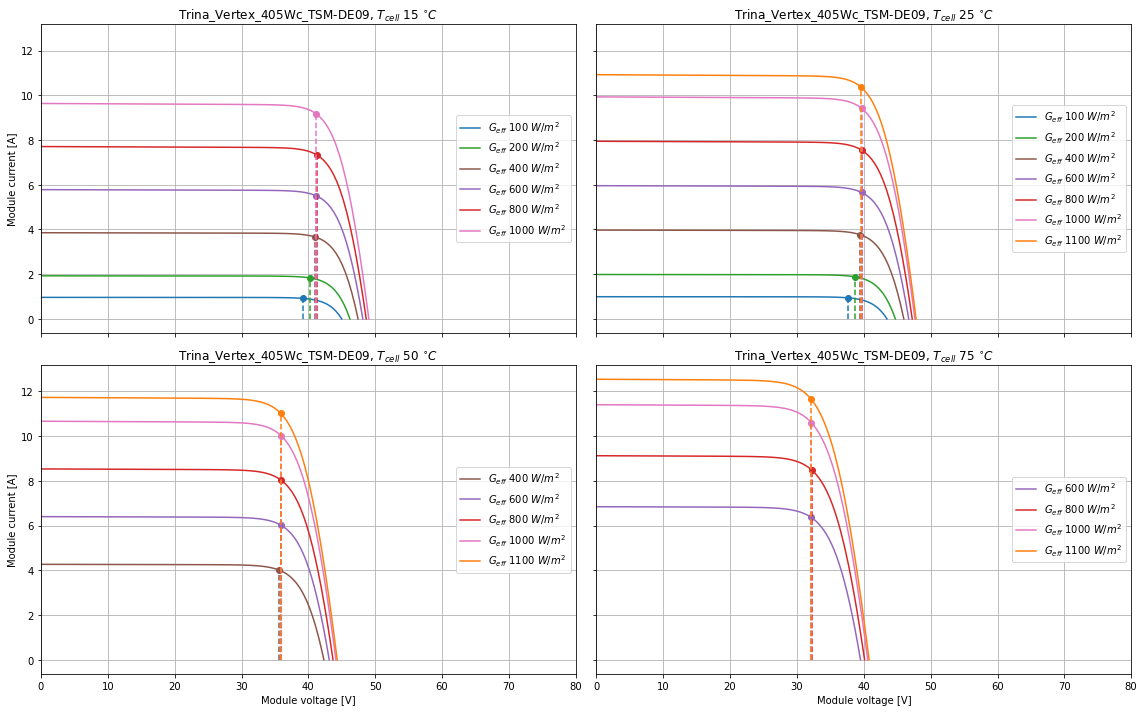

In [87]:
# plot the calculated curves:

exclude = [(1100, 15), (400, 75), (200, 50), (200, 75), (100, 50), (100, 75)]
kolor = ['#1f77b4', '#2ca02c', '#8c564b', '#9467bd', '#d62728', '#e377c2', '#ff7f0e']

f, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for m, irr in enumerate(E_IEC61853):
    for n, tc in enumerate(T_IEC61853):
        if (irr, tc) in exclude:
            continue
        i = n + 4*m
        j = n // 2, n % 2
        label = (
            "$G_{eff}$ " + f"{irr} $W/m^2$"
        )
        ax[j].plot(curve_info['v'][i], curve_info['i'][i], label=label, c=kolor[m])
        v_mp = curve_info['v_mp'][i]
        i_mp = curve_info['i_mp'][i]
        # mark the MPP
        ax[j].plot(v_mp, i_mp, ls='', marker='o', c=kolor[m])
        ax[j].vlines(v_mp, 0, i_mp, linestyle='dashed', color=kolor[m])
        # just repeat this every time doesn't hurt anyone
        ax[j].legend(loc='right')
        if j[0] == 1:
            ax[j].set_xlabel('Module voltage [V]')
        if j[1] == 0:
            ax[j].set_ylabel('Module current [A]')
        ax[j].set_title(f"{module_trina_vertex_405_CEC.get('Name')}, " + "$T_{cell}$ " + f"{tc} " + "$^{\circ}C$")
        ax[j].grid(True)
        ax[j].set_xlim([0, 80])

f.tight_layout()

### 1- Comparaison des modèles METEO

In [ ]:
# REFERENCE : fichier PV Watts horaire Montpellier, azimuth 180° (sud), tilt 0°.

filename = "c:/Users/benjamin.deporte/Documents/095_Code_Python_Toy/PV/Scenarii/Production/pvwatts_hourly_8505Wc_tilt0_for_NB.csv"

results_pvwatts = pd.read_csv(filename, sep=";", header=15, encoding='utf-8', nrows=8760) # dtype=dtype) #, converters=converters)

# Solar Irradiance = The total irradiance incident on the plane of photovoltaic array in kilowatt-hours per square meter per day. 
# PVWatts calculates the monthly and annual values from the hourly plane-of-array irradiance values, 
# which it calculates from hourly diffuse horizontal irradiance (DHI) and direct normal irradiance (DNI) data in the weather file for the location, 
# taking into consideration the position of the sun and the orientation of photovoltaic modules in the array.

In [ ]:
results_pvwatts

In [ ]:
# Valeurs annuelles :

print(f"Beam Irradiance = {results_pvwatts['Beam Irradiance (W/m^2)'].sum()/1000:.2f} kWh/an")
print(f"Diffuse Irradiance = {results_pvwatts['Diffuse Irradiance (W/m^2)'].sum()/1000:.2f} kWh/an")
print(f"POA Irradiance = {results_pvwatts['Plane of Array Irradiance (W/m^2)'].sum()/1000:.2f} kWh/an")

In [ ]:
# Comparaison avec pvlib

In [ ]:
# where is Pechbusque...
# latitude, longitude, name, altitude, timezone

coordinates = [
    (43.58, 3.97, 'Montpellier', 6.0, 'Europe/Paris'),
    (43.515, 1.465,'Pechbusque', 279.0, 'Europe/Paris')
]

In [ ]:
# récupère météo

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude, map_variables=True)[0]  # map_variables=True ?!
    weather.index.name = "utc_time"
    
    tmys.append(weather)
    
# tmys[0] est le temps à Montpellier

In [ ]:
tmys[0]

In [ ]:
tmys[1]

In [ ]:
# Valeurs annuelles :

print(f"\n -- MONTPELLIER (PVGis) --")
print(f"Direct Normal Irradiance = {tmys[0]['dni'].sum()/1000:.2f} kWh/an")
print(f"Diffuse Horizontal Irradiance = {tmys[0]['dhi'].sum()/1000:.2f} kWh/an")
print(f"GHI = {tmys[0]['ghi'].sum()/1000:.2f} kWh/an")

print(f"\n -- PECHBUSQUE (PVGis) --")
print(f"Direct Normal Irradiance = {tmys[1]['dni'].sum()/1000:.2f} kWh/an")
print(f"Diffuse Horizontal Irradiance = {tmys[1]['dhi'].sum()/1000:.2f} kWh/an")
print(f"GHI = {tmys[1]['ghi'].sum()/1000:.2f} kWh/an -- vs 1425 kWh/an sur le site PVGis")

### Conclusion 1 : 
- POA Irradiance = GHI ici (tilt 0°C) = 1465 kWh/an PV Watts vs 1588 kWh/an PVGIS (+123 kWh/an)
- Diffus : 666 kWh/an PV Watts vs 533 kWh PV GIS (-133 kWh/an)

### 2- Comparaison avec Etude SMA

In [ ]:
module_trina_vertex_405_for_pvwatts = {
    'pdc0' : 405.0, 
    'gamma_pdc' : -0.34e-2
    }

In [ ]:
inverter_sma_tri_TL_8kVA_for_pvwatts = {
    'pdc0' : 15000.0,
    'eta_inv_nom' : 0.98,
    'eta_inv_ref' : 0.98
}

In [ ]:
losses_parameters_for_pvwatts = {
    'losses' : 14.08
        # float(pvlib.pvsystem.pvwatts_losses())
    }

array_losses_parameters_for_pvwatts = {
    'dc_ohmic_percent' : 1.0
}

In [ ]:
# # Construction d'un système avec algorythme PV Watts

# from pvlib.pvsystem import PVSystem, Array, FixedMount
# from pvlib.location import Location
# from pvlib.modelchain import ModelChain

# results = {}

# temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# for location, weather in zip(coordinates, tmys):
#     latitude, longitude, name, altitude, timezone = location
    
#     location = Location(
#         latitude,
#         longitude,
#         name=name,
#         altitude=altitude,
#         tz=timezone,
#     )
    
#     mount = FixedMount(surface_tilt=0.0, surface_azimuth=180.0)
    
#     array = Array(
#         mount=mount,
#         module_parameters=module_trina_vertex_405_for_pvwatts,
#         temperature_model_parameters=temperature_model_parameters,
#         modules_per_string=21,
#         strings=1,
#         array_losses_parameters=array_losses_parameters_for_pvwatts
#     )
      
#     system = PVSystem(arrays=[array],
#                       inverter_parameters=inverter_sma_tri_TL_8kVA_for_pvwatts,
#                       losses_parameters=losses_parameters_for_pvwatts
#                       )
    
    
#     mc = ModelChain.with_pvwatts(system,
#                                  location
#                                  )
    
#     mc.run_model(weather)
        
#     results[name] = mc.results

In [ ]:
r = results['Montpellier']

In [ ]:
# On regarde d'abord ce que le modèle a utilisé comme irradiance...

r.total_irrad

In [ ]:
list_poa = ['poa_global', 'poa_direct', 'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse']

for p in list_poa:
    print (f"{p} = {r.total_irrad[p].sum()/1000:.2f} kWh/an")


In [ ]:
# on regarde maintenant la sortie DC

r.dc

In [ ]:
print(f"DC Output = {r.dc.sum()/1000:.2f} kWh/an")

In [ ]:
print(f"AC Output = {r.ac.sum()/1000:.2f} kWh/an")

In [ ]:
#-----------------------------------------------------------------------------------------------------
# données module Trina : sources = datasheet Trina, base CEC, autres info reprises de la db SAM
#-----------------------------------------------------------------------------------------------------

module_trina_vertex_405 = {
    "Vintage" : 2021,  # datasheet info
    "Area" : 1.91,
    "Material" : "Mono-c-Si", # datasheet info
    "Cells_in_Series" : 60, # CEC database info
    "Parallel_Strings" : 2, # CEC database info
    "Isco" : 12.34, # short circuit current : datasheet info
    "Voco" : 41.4, # open circuit voltage : datasheet info
    "Impo" : 11.77, # max power current : datasheet info
    "Vmpo" : 34.4, # max power voltage : datasheet info
    "Aisc" : 0.0004, # short circuit temperature coefficient : datasheet info plus pénalisante que CEC info
    "Aimp" : 0.0004, # maximum power temperature coefficient : inconnu, on reconduit Aisc
    "C0" : 1.01284, # coefficients relating Im p to G : ?
    "C1" : -0.01284, # coefficients relating Im p to G : ?
    "Bvoco" : -0.266, # open circuit temperature coefficient : CEC info plus pénalisante que datasheet info 
    "Mbvoc" : 0, # relates βoc,re f to effective irradiance : 0 ?
    "Bvmpo" : -0.266, # maximum power voltage temperature coefficient : inconnnu, on reconduit Bvoco
    "Mbvmp" : 0, # relates βm p,re f to effective irradiance : 0 ?
    "N" : 1.4032, # diode factor : ?
    "C2" : 0.279317, # coefficients relating Vm p to G : ?
    "C3" : -7.24463, # coefficients relating Vm p to G : ?
    "A0" : 0.928385, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A1" : 0.068093, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A2" : -0.015774, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A3" : 0.001661, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A4" : -0.000069, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "B0" : 1, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B1" : -0.002438, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B2" : 0.00031, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B3" : -0.000012, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B4" : 0.0, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B5" : -0.0, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "DTC" : 3.0, # ??
    "FD" : 1, # fraction of diffuse irradiance used by module
    "A" : -3.40641, # ??
    "B" : -0.084208, # ??
    "C4" : 0.996446, # coefficients relating Ix to G : ?
    "C5" : 0.003554, # coefficients relating Ix to G : ?
    "IXO" : 4.97599, # ?
    "IXXO" : 3.18803, # ?
    "C6" : 1.15535, # coefficients relating Ixx to G : ?
    "C7" : -0.155353, # coefficients relating Ixx to G : ?
    "Notes" : "Format SAM model, Source: CEC database, 11-Aug-2022",
    "Name" : "Trina_Vertex_405Wc_TSM-DE09"
}

In [ ]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur Référence : SMA Tripower 8.0 -----------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_sma_tri_TL_8kVA = {
    "Vac" : 480.0, # Nominal voltage, -- inchangé -- essai à 230 : non, essai à 380 neg ; essai à 480
    "Pso" : 44.0, # Power consumption during operation -- inchangé
    "Paco" : 8000.0, # Maximum AC power - ok
    "Pdco" : 15000.0, # Maximum DC power - changé de 12000 à 15000
    "Vdco" : 580.0, # Nominal DC voltage - changé de 600 à 580
    "C0" : -7.06449e-07, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "Pnt" : 3.6, # Inverter night time loss : ? -- inchangé -- essai à 3.6
    "Vdcmax" : 1000.0, # Maximum DC voltage -- ok
    "Idcmax" : 20.0, # Maximum DC current -- ok
    "Mppt_low" : 260.0, # min MPP voltage -- changé de 330 à 260
    "Mppt_high" : 800.0, # max MPP voltage -- inchangé
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [ ]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur SMA Tripower Smart Energy --------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_sma_tripower_sme = {
    "Vac" : 230.0, # Nominal voltage,
    "Pso" : 44.0, # Power consumption during operation
    "Paco" : 8000.0, # Maximum AC power
    "Pdco" : 12000.0, # Maximum DC power
    "Vdco" : 600.0, # Nominal DC voltage
    "C0" : -7.06449e-07, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "Pnt" : 0.075, # Inverter night time loss : ?
    "Vdcmax" : 1000.0, # Maximum DC voltage
    "Idcmax" : 20.0, # Maximum DC current
    "Mppt_low" : 330.0, # min MPP voltage
    "Mppt_high" : 800.0, # max MPP voltage
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [ ]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur custom ---------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_custom = {
    "Vac" : 380.0, # Nominal voltage, 
    "Pso" : 44.0, # Power consumption during operation -- inchangé
    "Paco" : 8000.0, # Maximum AC power
    "Pdco" : 15000.0, # Maximum DC power
    "Vdco" : 580.0, # Nominal DC voltage
    "C0" : -1e-6, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "Pnt" : 3.6, # Inverter night time loss : ? -- inchangé -- essai à 3.6
    "Vdcmax" : 1000.0, # Maximum DC voltage
    "Idcmax" : 30.0, # Maximum DC current
    "Mppt_low" : 260.0, # min MPP voltage
    "Mppt_high" : 800.0, # max MPP voltage
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [ ]:
# # module, onduleur...

# sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
# sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# # module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
# module = pd.Series(module_trina_vertex_405)
# # inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
# inverter = pd.Series(inverter_sma_tripower_sme)

# inverter_ref = sapm_inverters['SMA_America__STP12000TL_US_10__480V_']  # SMA Tri 12kVA
# module_ref = sandia_modules['Suniva_Titan_240__2009__E__']   # module ancien à 240 Wc

# temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [ ]:
# sandia_modules.transpose().to_csv('../Databases/sandia_modules.csv')  # dernier update = 2012 ?!
# sapm_inverters.transpose().to_csv('../Databases/sapm_inverters.csv')  # dernier update = 

In [ ]:
# module = module_trina_vertex_405
# inverter = inverter_sma_tri_ref_8kVA

In [ ]:
# # Design PV OOP

# from pvlib.pvsystem import PVSystem, Array, FixedMount
# from pvlib.location import Location
# from pvlib.modelchain import ModelChain

# energies = {}

# for location, weather in zip(coordinates, tmys):
#     latitude, longitude, name, altitude, timezone = location
    
#     location = Location(
#         latitude,
#         longitude,
#         name=name,
#         altitude=altitude,
#         tz=timezone,
#     )
    
#     mount = FixedMount(surface_tilt=0.0, surface_azimuth=180.0)
    
#     array = Array(
#         mount=mount,
#         module_parameters=module,
#         temperature_model_parameters=temperature_model_parameters,
#         modules_per_string=21,
#         strings=1
#     )
    
#     system = PVSystem(arrays=[array], inverter_parameters=inverter)
    
#     mc = ModelChain(system, location,
#                     spectral_model='no_loss',  # on essaie spectral model = no loss...
#     )
    
#     mc.run_model(weather)
#     annual_energy = mc.results.ac.sum()
    
#     energies[name] = annual_energy

# energies = pd.Series(energies)

# energies.plot(kind='bar', rot=0)

# plt.ylabel('Yearly energy yield (W hr)')